primero se lleva a cabo la limpieza del todas las variables preexistentes que se tuvieran asi como de la consola

In [1]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
     pass

C:\Users\luisd\AppData\Local\Temp\ipykernel_18096\3685520888.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')


C:\Users\luisd\AppData\Local\Temp\ipykernel_18096\3685520888.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


Se cargan las librerias con las que funciona el script

In [2]:
import cv2 as cv #libreria para el procesamiento de imagenes
import numpy as np #no se que haga pero funciona xD
import glob #liberia para leer archivos de las carpetas
import os #libreria para establecer y moverse del directorio de trabajo
import pandas as pd #esta libreria es para generar el data frame del resultado final
import matplotlib.pyplot as plt #esta libreria es para plotear dentro de la consola en python
import matplotlib.image
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw #esta libreria hace el recorte de la parte de enmedio

la variable "n_K" es un int que almacena el numero de clusters que se utilizaran para realizar la segmentacion de la imagen

In [3]:
n_K = input('numero de clusters para la segmentacion de imagen? (max:5):')
n_K = int(n_K)

organizacion de carpetas de entrada y de salida

In [4]:
OutputROI = "ROI_Cropped"
OutputROISample = "ROI_Reconstruction"

In [5]:
Inputpath = "C:\\Users\\luisd\\Documents\\GitHub\image_kmeans_processing\\venv_testing_311\\Input"
Outputpath = "C:\\Users\\luisd\\Documents\\GitHub\image_kmeans_processing\\venv_testing_311\\Output"
ROI_Cropped_Outputpath = os.path.join(Outputpath,OutputROI)
ROI_Sample_Outputpath = os.path.join(Outputpath,OutputROISample)

agregar aqui una funcion de identificar primero si ya existen no crearlas y caso contrario generarlas carpetas

In [6]:
#generacion de la carpeta para la salida de datos
os.mkdir(ROI_Cropped_Outputpath)
os.mkdir(ROI_Sample_Outputpath)


In [10]:
#se cambia la carpeta de trabajo a la definida por inputpath 
os.chdir(Inputpath)
#se genera una lista de todas las fotos que se encuentran en la carpeta de input
img_list = glob.glob('*jpg')
#se cuenta el tamaño de la lista y se asigna a la variable a1
a1 = len(img_list)

In [12]:
#funcion para convetir colores RGB a formato Hexagesimal
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

el objetivo de esta seccion es generar una imagen binaria, para esto el procedimiento es el siguiente:
reescalar -> transformar la imagen a una matriz cubica -> encontrar 2 centros en dicha matriz -> reconstruir el cubo utilizando estos centros -> convertir a una imagen en escala de grises -> convertir a una imagen binaria utilizando OTSU

In [13]:
x=0
img_list[0]

'test1.jpg'

In [14]:
def Crop_plate(img):
    Input_img=cv.imread(img)
    Input_img=cv.resize(Input_img,(1000,1000), interpolation=cv.INTER_AREA)
    Work_img=Input_img.reshape((Input_img.shape[0])*Input_img.shape[1],3)
    Work_img=np.float32(Work_img)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    K = 2
    attempts=10
    ret,label,center=cv.kmeans(Work_img,K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res=center[label.flatten()]
    result_image=res.reshape((Input_img.shape))
    result_image=cv.cvtColor(result_image,cv.COLOR_RGB2GRAY)
    ret,otsu=cv.threshold(result_image,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    edge=cv.Canny(otsu,10,20)
    edge_coordinates = np.argwhere(edge>0)
    y1,x1=edge_coordinates.min(axis=0)
    y2,x2=edge_coordinates.max(axis=0)
    ROI=Input_img[y1:y2,x1:x2]
    ROI=cv.resize(ROI,(500,500), interpolation=cv.INTER_AREA)
    print("ROI Localizada")
    return ROI


In [15]:
ROI = Crop_plate(img_list[0])

ROI Localizada


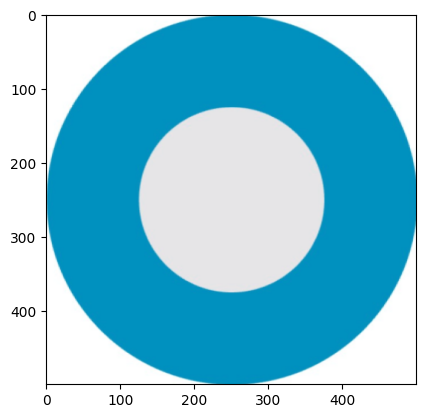

In [16]:
plt.imshow(ROI)

In [17]:
#se cambia el directorio de la carpeta de entrada de datos a la carpeta de salida 
os.chdir(ROI_Cropped_Outputpath)
#se genera la imagen resultado
cv.imwrite(img_list[x],ROI)

True

In [18]:
def Center_Crop(img):
    Input_img = Image.open(img)
    height,width = Input_img.size
    lum_img = Image.new('L',[height,width],0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(10,10), (490,490)], 0, 360, fill=255, outline='black')
    img_arr = np.array(Input_img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr,lum_img_arr))
    matplotlib.image.imsave(img,final_img_arr)
    Input_img = Image.open(img)
    Input_img = Input_img.convert('RGB')
    reference1 = (20,20)
    color_reference = (0,0,0)
    bucket_img = ImageDraw.floodfill(Input_img, reference1, color_reference, thresh=50)
    Output_img = Input_img.save(img)
    print("Centro Recortado")
    return Output_img

In [19]:
Output_img = Center_Crop(img_list[0])

Centro Recortado


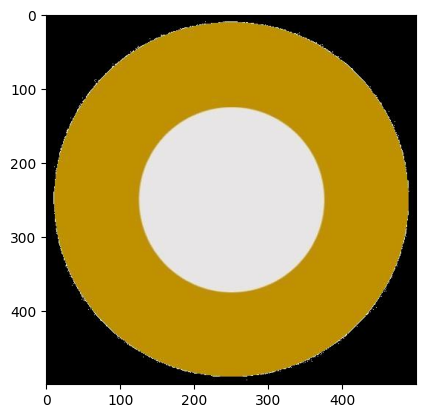

In [20]:
Output_img=cv.imread(img_list[0])
Output_img=cv.cvtColor(Output_img,cv.COLOR_BGR2RGB)
plt.imshow(Output_img)

In [23]:
def Image_segmentation(img):
    Input_img=cv.imread(img)
    Sample=Input_img[200:300,50:320]
    hsv_img=cv.cvtColor(Input_img,cv.COLOR_BGR2HSV)
    hsv2_img=Sample
    hsv2_img=cv.cvtColor(hsv2_img,cv.COLOR_BGR2HSV)
    h,s,v=cv.split(hsv2_img)
    ret_h, otsu= cv.threshold(h, 0,177, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_s, otsu= cv.threshold(s, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_v, otsu= cv.threshold(v, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_h=int(ret_h)
    ret_s=int(ret_s)
    ret_v=int(ret_v)
    lower = np.array([ret_h,0,ret_v])
    upper = np.array([177,ret_v,255])
    mask=cv.inRange(hsv_img,lower,upper)
    Segmented_img=cv.bitwise_and(Input_img,Input_img,mask=mask)
    cv.imwrite(img,Segmented_img)
    print("Imagen segmentada")
    return Segmented_img


In [24]:
Segmented_img = Image_segmentation(img_list[0])

Imagen segmentada


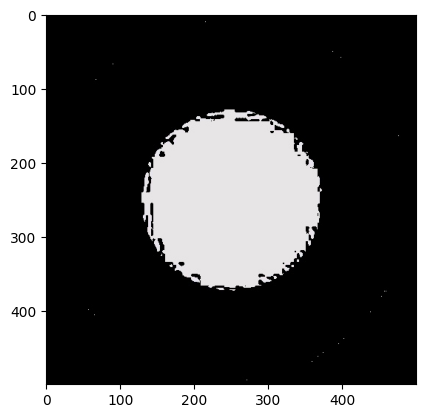

In [25]:
Segmented_img=cv.imread(img_list[0])
Segmented_img=cv.cvtColor(Segmented_img,cv.COLOR_BGR2RGB)
plt.imshow(Segmented_img)

In [32]:
def Image_reconstruction(img):
    ROI=cv.imread(img)
    ROI=cv.cvtColor(ROI,cv.COLOR_BGR2RGB)
    attempts=20
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    reshape_ROI=np.float32(ROI.reshape(ROI.shape[0]*ROI.shape[1],3))
    ret,label,ROIcenter=cv.kmeans(reshape_ROI,n_K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
    _,counts =np.unique(label, return_counts=True)
    fin = ROIcenter[label.flatten()]
    final_image = fin.reshape((ROI.shape))
    final_image = cv.cvtColor(final_image, cv.COLOR_BGR2RGB)
    HEXcolors = [0]
    Frequency =[0]
    R_array = [0]
    G_array = [0]
    B_array = [0]
    z=0
    y=0
    ROIcenter=np.uint8(ROIcenter)
    for y in range(n_K):
        HEXcolors.append(rgb_to_hex(ROIcenter[y]))
        Frequency.append(counts[y])
        R_array.append(ROIcenter[y,z])
        G_array.append(ROIcenter[y,z+1])
        B_array.append(ROIcenter[y,z+2])
    result_table = pd.DataFrame({'HEXcolors':HEXcolors,'Frequency':Frequency,'R':R_array,'G':G_array,'B':B_array})
    result_table = result_table.iloc[1: , :]
    return result_table

In [33]:
Image_reconstruction(img_list[0])

,HEXcolors,Frequency,R,G,B
1,#000000,206140,0,0,0
2,#e7e5e6,43860,231,229,230
